In [2]:
import numpy as np
import pandas as pd
import keras
from collections import defaultdict
from matplotlib import pyplot as plt
import seaborn as sns
import langid
from keras import backend as K

from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import minmax_scale

Using TensorFlow backend.


### Métrica de performance
Decidimos utilizar la métrica **F1-Scrore**. con el objetivo de poder establecer una relación entre **Precission y Recall** ya que a través de Precission que nos interesará ser precisos en los casos en los que queremos estar seguros de hacer una predicción correcta. Por otro lado, a través de recall nos permitirá que la predicción sea la correcta en la mayoría de los casos. 
Es necesario tomar ambas métricas con el fin de construir los mejores modelos posibles. 

Cabe mencionar, que en nuestro caso Accuracy no sería una métrica correcta para medir nuestros modelos ya que el dataset está muy desbalanceado. 


In [3]:
#data = pd.read_csv("C:/Users/juana/test/csvFake.csv")
data = pd.read_csv("./fake_job_postings.csv")

In [4]:
data.head()


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## Pre procesamiento de datos 
Debemos llevar a cabo nuevamente lo implementado en el TP n°1 con todo lo que respecta a la limpieza y pre procesamiento de los 
datos. 

In [171]:
#Rellenamos valores nulos por "Desconocido"
categorias_columnas = ['employment_type', 'required_experience', 'required_education']
for col in categorias_columnas:
    data[col].fillna("unknown", inplace=True)

In [172]:
#Se eliminan las columnas que no consideramos importantes en la predicción.
data = data.drop(['job_id', 'department', 'industry', 'function','salary_range'], axis=1)

In [173]:
txt_columnas = ['company_profile', 'description', 'requirements', 'benefits']

data = data.dropna(subset=txt_columnas, how='all')

for col in txt_columnas:
    data[col].fillna('', inplace=True)


### Feature engineering

Como mencionamos en el trabajo práctico n°1 intentaremos determinar la vericidad de un anuncio de acuerdo a la cantidad de palabras que se encuentran en algunas de las variables de entrada de nuestro data set. Nuestra idea consiste en generar nuevas variables que contengan la cantidad de palabras contenidas en las features de cada uno de los artículos. 
Analizaremos mediante un gráfico la cantidad de palabras de las features: "company_profile", "description", "requiriments", "benefits", las cuales consideramos de mayor importancia a la hora de predecir. 

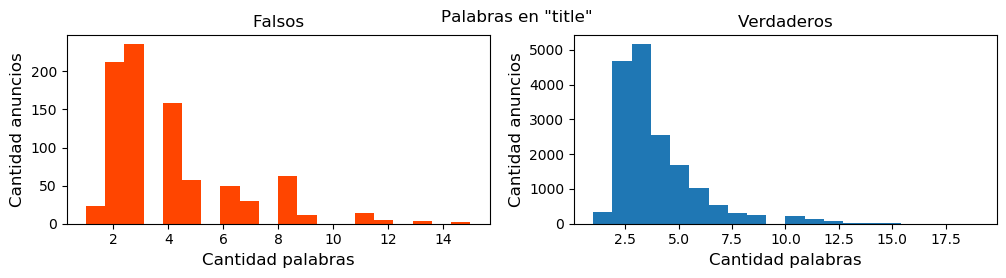

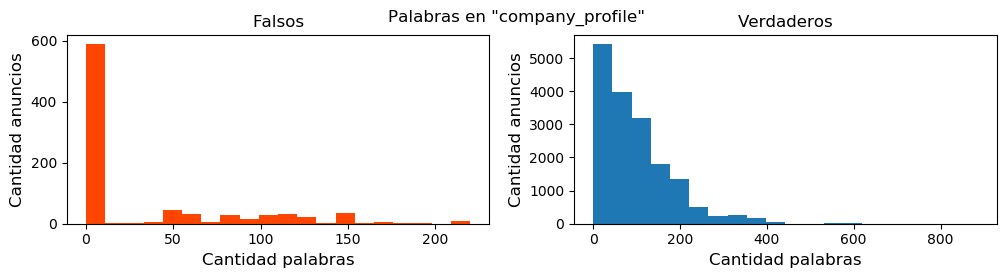

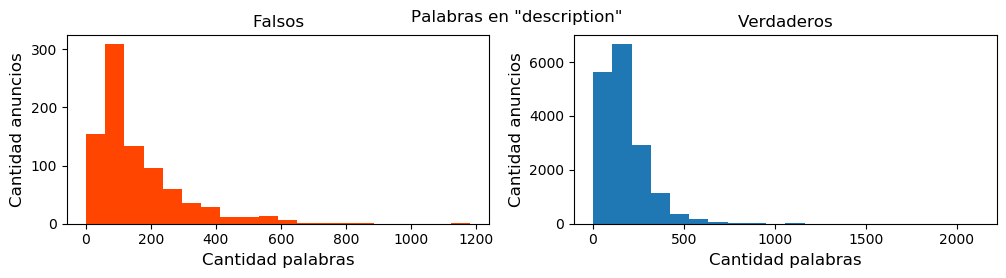

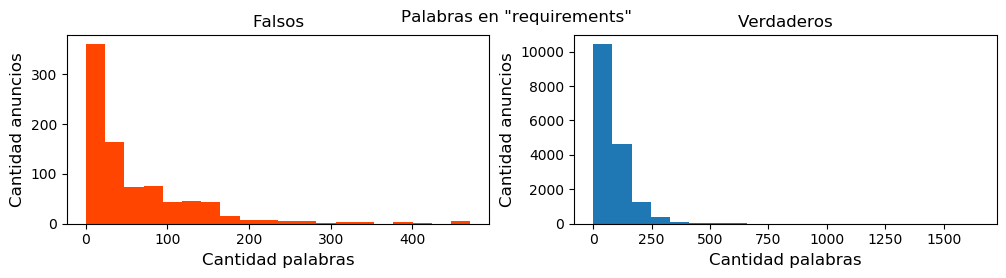

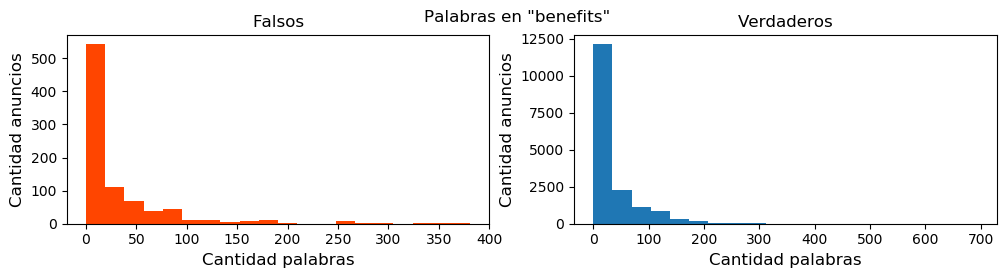

In [174]:
columnas = ['title','company_profile', 'description', 'requirements', 'benefits']

for columna in columnas:
    fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(12, 2.5), dpi=100)
    cantidadPalabrasFalsos=data[data.fraudulent==1][columna].str.split().map(lambda x: len(x))
    ax1.set_ylabel('Cantidad anuncios', fontsize=12) #Descripcion eje y
    ax1.set_xlabel('Cantidad palabras', fontsize=12) #Descripcion eje x
    ax1.hist(cantidadPalabrasFalsos,bins = 20,color='orangered')
    ax1.set_title('Falsos')
   
    cantidadPalabrasVerdaderos=data[data.fraudulent==0][columna].str.split().map(lambda x: len(x))
    ax2.hist(cantidadPalabrasVerdaderos, bins = 20)
    ax2.set_title('Verdaderos')
    fig.suptitle(f'Palabras en "{columna}"')
    ax2.set_ylabel('Cantidad anuncios', fontsize=12) #Descripcion eje y
    ax2.set_xlabel('Cantidad palabras', fontsize=12) #Descripcion eje x

De acuerdo a lo observado en las gráficas anteriores, se puede afirmar que un anuncio falso intentará parecerse lo más posible a uno que no lo es. Sin embargo, notamos  en las gráficas anteriores que hay algunas diferencias mínimas.

Intentaremos predecir de acuerdo a la cantidad de palabras con las que cuenta cada anuncio en sus respectivas columnas mencionadas recientemente. Para esto, necesitamos crear nuevas features.

#### Crear features extrayendo información de otras features

In [175]:
#Sumamos la cantidad de palabras que tiene cada anuncion en : title, company_profile, description, requirements, benefits.
#Colocamos la suma de cada una de las feature en una nueva columna denominada (nombreCol)_cantPalabras

columnas = ['title','company_profile', 'description', 'requirements', 'benefits'] 

for columna in columnas:
    cantidadPalabras=data[columna].str.split().map(lambda x: len(x))  #Cuento cantidad de palabras
    cantidades = data[columna].str.count(' ')     #Cuento cantidad de espacios en cada casillero
    data.insert(9, columna+"_cantPalabras", cantidadPalabras, allow_duplicates = False) #Inserta nueva columna _cantPalabras
    data[columna+"_cantPalabras"].fillna('0', inplace=True) #Se reemplaza por 0 las filas NaN

### Entrenamiento de modelos:

In [176]:
# separamos los datos
# 60% train, 20% test, 20% validation

train, not_train = train_test_split(data, test_size=0.4, random_state=42)
validation, test = train_test_split(not_train, test_size=0.5, random_state=42)

In [177]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder,LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.pipeline import Pipeline


In [178]:
sample = train.sample(5, random_state=42)
complete_mapper = DataFrameMapper([
    (['title_cantPalabras'], [StandardScaler()]),
    (['company_profile_cantPalabras'], [StandardScaler()]),
    (['description_cantPalabras'], [StandardScaler()]),
    (['requirements_cantPalabras'], [StandardScaler()]),
    (['benefits_cantPalabras'], [StandardScaler()]),
    
])

complete_mapper.fit(train)

display('Sample transformado con mean')
display(complete_mapper.transform(sample))

'Sample transformado con mean'

array([[-0.3678266 ,  0.92554828, -0.0865315 ,  0.38678274,  0.75721771],
       [-0.8564552 ,  0.04066699,  2.05432753,  1.99269146, -0.60173069],
       [-0.3678266 ,  0.43653494, -0.37627182,  0.85261886, -0.60173069],
       [ 0.6094306 ,  0.05231017,  2.71429159, -0.96169024, -0.60173069],
       [ 0.6094306 , -1.08872097,  6.51310911, -0.96169024, -0.60173069]])

In [179]:
def evaluate_model(model, set_names=('train', 'test'), title='', show_cm=True):
    if title:
        display(title)
    final_metrics = defaultdict(list)
    if show_cm:
        fig, axis = plt.subplots(1, len(set_names), sharey=True, figsize=(15, 3))
    
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'test', 'validation']
        set_data = globals()[set_name] # <- hack feo...

        y =set_data.fraudulent
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred))
        
        if show_cm:
            ax = axis[i]
            sns.heatmap(metrics.confusion_matrix(y, y_pred), ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=False)

            ax.set_title(set_name)
            ax.xaxis.set_ticklabels(['verdadero', 'falso'])
            ax.yaxis.set_ticklabels(['verdadero', 'falso'])
            ax.set_xlabel('Predicted class')
            ax.set_ylabel('True class')

        
    display(pd.DataFrame(final_metrics, index=set_names))
    if show_cm:
        plt.tight_layout()
        plt.show()

## Modelo n°1: LogisticRegression

Comenzamos con este modelo ya que es el mas fácil de comprender.

In [180]:
lr_model_si = Pipeline([
    ('mapper', complete_mapper),
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', LogisticRegression(random_state=42)),
])

lr_model_si.fit(train, train.fraudulent)

y_pred = lr_model_si.predict(train)

y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

,Accuracy,Precision,Recall,F1
train,0.951711,0.0,0.0,0.0
test,0.949385,0.0,0.0,0.0


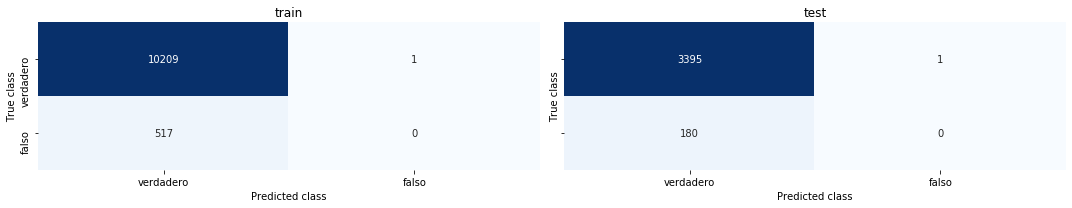

In [181]:
evaluate_model(lr_model_si)

### Análisis de resultados LogisticRegression

De acuerdo a lo observado, podemos concluir con que este modelo no es el apropiado para nuestro caso ya que no es linealmente divisibe, esto queda demostrado por los bajos valores que expresan las metricas seleccionadas. Accuracy no debe ser tenido en cuenta debido a que estamos trabajando con un dataset muy desbalanceado.

## Modelo n°2: Random Forest

Sin obtener resultados aceptables en el modelo anterior, decidimos continuar con la misma idea, intentar realizar predicciones de acuerdo a la cantidad de palabras presentes en las mismas columnas ya mencionadas, pero esta vez probando con **Random Forest**.


'Random Forest'

,Accuracy,Precision,Recall,F1
train,0.998881,0.998028,0.978723,0.988281
test,0.967562,0.847826,0.433333,0.573529


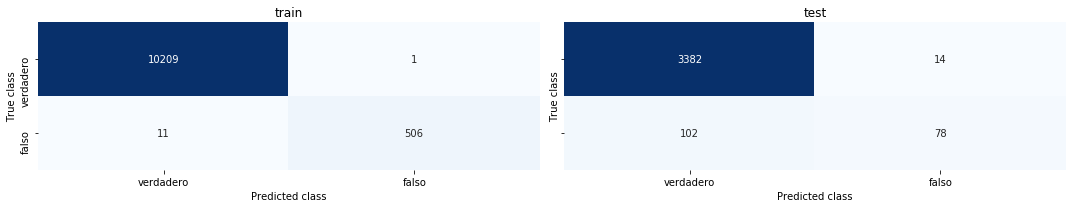

In [182]:
random_forest_model = Pipeline([
    ('mapper', complete_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', RandomForestClassifier()),
])

random_forest_model.fit(train, train.fraudulent)

evaluate_model(random_forest_model, title='Random Forest')

Podemos observar a simple vista, que los resultados obtenidos son muucho mejor que en el modelo anterior. Sin embargo, observando las métricas detalladas, nos damos cuenta que existe un sobreentramiento. Es por esto, que necesitamos hacer algún cambio en los hiperparámetros.

'Random Forest'

,Accuracy,Precision,Recall,F1
train,0.974271,0.995885,0.468085,0.636842
test,0.965324,0.951613,0.327778,0.487603


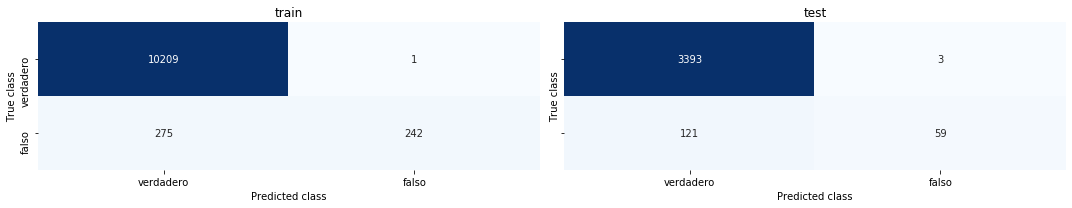

In [183]:
#Limitando la profundidad del árbol, logramos tener un mejor resultado, logrando que el modelo no esté sobreentrenado. 
random_forest_model = Pipeline([
    ('mapper', complete_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', RandomForestClassifier(max_depth=12, n_estimators= 100)),
])

random_forest_model.fit(train, train.fraudulent)

evaluate_model(random_forest_model, title='Random Forest')

In [184]:
evaluate_model(random_forest_model, title='Random Forest', set_names=('train', 'test', 'validation'), show_cm=False)

'Random Forest'

,Accuracy,Precision,Recall,F1
train,0.974271,0.995885,0.468085,0.636842
test,0.965324,0.951613,0.327778,0.487603
validation,0.963926,0.882353,0.267857,0.410959


Los resultados siguen sin ser los esperados, por ende, comenzaremos a manejar la idea de poder predecir de acuerdo al análisis de texto

#### Crear features extrayendo información de otras features

In [5]:
#lectura nuevamente del dataset
data = pd.read_csv("./fake_job_postings.csv")


In [186]:
#reemplazamos nulls en ciertas columnas por espacios en blanco.
txt_columnas = ['company_profile', 'description', 'requirements', 'benefits']

data = data.dropna(subset=txt_columnas, how='all')

for col in txt_columnas:
    data[col].fillna('unknown', inplace=True)

In [187]:
#unimos el texto de ciertas columnas en una sola.
columnas = ['company_profile', 'description', 'requirements', 'benefits']

data['text_combine'] = data[columnas].apply(lambda x: ' '.join(x), axis=1)

#eliminamos el resto de las columnas que no nos interesan
data = data.drop(['job_id', 'department', 'industry', 'function','salary_range','description','company_profile','requirements'
                 ,'benefits','title','location','telecommuting','has_company_logo','employment_type','required_experience',
                 'required_education','has_questions'], axis=1)

data.head()



,fraudulent,text_combine
0,0,"We're Food52, and we've created a groundbreaki..."
1,0,"90 Seconds, the worlds Cloud Video Production ..."
2,0,Valor Services provides Workforce Solutions th...
3,0,Our passion for improving quality of life thro...
4,0,SpotSource Solutions LLC is a Global Human Cap...


La idea consiste en generar una nueva columna a partir de los textos de las otras variables de entrada.
El contenido de las variables que añadiremos en una nueva columna son: **"title", "company_profile", "description" , "benefits", "requirements"**.

### Procesamiento de la nueva feature

Luego de generar la nueva feature será necesario realizar algunos cambios en las mismas. 
Para comenzar, sabemos que la mayoría de los anuncios están en inglés, por ende, comenzaremos a eliminar aquellos anuncios que tengan otro idioma que no sea el inglés.

In [188]:
import langid

In [189]:
def detectar_lenguaje(texto):
    codigo,_ = langid.classify(texto)
    
    return codigo

data = data[data['text_combine'].apply(lambda x: detectar_lenguaje(x) == 'en')]

data.head()

,fraudulent,text_combine
0,0,"We're Food52, and we've created a groundbreaki..."
1,0,"90 Seconds, the worlds Cloud Video Production ..."
2,0,Valor Services provides Workforce Solutions th...
3,0,Our passion for improving quality of life thro...
4,0,SpotSource Solutions LLC is a Global Human Cap...


In [190]:
##consultamos la cantidad de filas que se eliminaron por no tener la columna "text_combine" en idioma inglés.
data.count()

fraudulent      17700
text_combine    17700
dtype: int64

Luego, lo que haremos es pasar todas palabras de la columna con la cual trabajaremos a letra minúscula con el fin de que las palabras en mayúscula no tengan más peso que las demás.

Por otro lado, eliminaremos saltos de líneas, signos de puntuación. 

In [191]:
#Limpiar texto

import string, re

def prepararTexto(texto):
    texto = texto.lower()                                               # Convertir el texto en minuscula
    texto = texto.replace('\n', ' ').replace('\r', '')                  # Eliminar saltos de linea
    texto = texto.replace(" ()","")                                     # Eliminar texto en parentesis
    texto = re.sub('[%s]' % re.escape(string.punctuation), '', texto)   # Eliminar signos de puntuacion
    return texto

data['text_combine'] = data['text_combine'].apply(lambda x: prepararTexto(x))

data.head()

,fraudulent,text_combine
0,0,were food52 and weve created a groundbreaking ...
1,0,90 seconds the worlds cloud video production s...
2,0,valor services provides workforce solutions th...
3,0,our passion for improving quality of life thro...
4,0,spotsource solutions llc is a global human cap...


Comenzaremos a utilizar algoritmos de procesamiento de texto vistos en clase

In [192]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import plot_confusion_matrix

#Separamos los datos con los cuales vamos a trabajar. 
dt_x = data['text_combine']
dt_y = data['fraudulent']

cvPrueba= CountVectorizer()

# separamos los datos de entrenamiento y test
x_train, x_test, y_train,y_test= train_test_split(dt_x,dt_y, test_size=0.4, random_state=42)


resultado = cvPrueba.fit_transform(["Hola, esto es una prueba", "Hola, esto no es una prueba"])


Como se ven los datos transformados con CountVectorizer:

In [193]:
resultado.toarray()

array([[1, 1, 1, 0, 1, 1],
       [1, 1, 1, 1, 1, 1]], dtype=int64)

Si queremos observar cuales son las palabras transformadas:


In [194]:
cvPrueba.get_feature_names()

['es', 'esto', 'hola', 'no', 'prueba', 'una']

## Modelo n° 3: KNeighbors

##MÉTRICAS##
Random Forest Accuracy: 0.9682203389830508
Random Forest Recall: 0.5887323943661972
Random Forest Pressicion: 0.7256944444444444
Random Forest F1: 0.6500777604976673


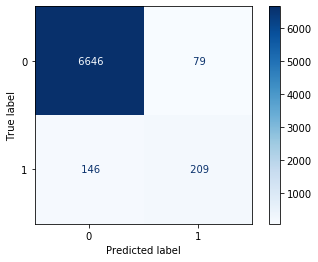

In [195]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

knn = KNeighborsClassifier(n_neighbors=5)


#Separamos los datos
dt_x = data['text_combine']
dt_y = data['fraudulent']

cv = CountVectorizer()

# proporcionamos datos que utilizaremos en train y test. 
x_train, x_test, y_train,y_test= train_test_split(dt_x,dt_y, test_size=0.4, random_state=42)

#comparamos

knn_model = Pipeline([('vectorizer', cv),
                 ('classifier', knn)])

#entrenamos
knn_model.fit(x_train,y_train)

#prediccion=
predicted = knn_model.predict(x_test)

# Model Accuracy
print('##MÉTRICAS##')
print("Random Forest Accuracy:", accuracy_score(y_test, predicted))
print("Random Forest Recall:", recall_score(y_test, predicted))
print("Random Forest Pressicion:", precision_score(y_test, predicted))
print("Random Forest F1:", f1_score(y_test, predicted))


plot_confusion_matrix(knn_model, x_test, y_test, cmap='Blues', values_format=' ')


## Técnica para garantizar que los modelos no sobreentrenen

Para garantizar que los modelos no sobreentrenen decidimos utilizar como métrica la matriz de confusión, la cual nos permite comparar de manera visual los resultados obtenidos en train y test.

## Informar al cliente:

El valor final de la métrica es: 0.65, esto indica una ponderación entre la cantidad de falsos positivos que estamos dispuestos a aceptar y la probabilidad de que no se nos escape un caso positivo. 

Al cliente podemos decirle que tenemos una certeza de predicción aproximada al 60% al decir si un anuncio es real o fake. 
Sin embargo, consideramos que dicha predicción es muy pequeña y aún no es suficiente para poder trabajar con ella en un ámbito que no perteneza a la prueba, ya que sería demasiado riesgoso. 


## Conclusiones:

Nuestra idea principal siempre fue poder predecir de acuerdo a la cantidad de palabras de ciertas variables de entrada, sin embargo, luego de probar dos algoritmos distintos, nos dimos cuenta, que la manera de enfrentar este tipo de problemas, iba más hacia el lado del análisis de texto. 

**¿Por qué consideramos que fallaron tanto el modelo de Logistic Regression como Random Forest?**
Consideramos que la causa principal eran las variables que estábamos utilizando para predecir. Los datos que estábamos utilizando, no eran lo suficientemente útiles para que el modelo pueda aprender a diferenciar ambos anuncios, ya que como aclaramos en un principio, los "fake" en cuanto a la cantidad de palabras de sus textos eran muy similares a los reales. 

**Resultados de Logistic Regression:** 
De acuerdo a lo observado, podemos concluir con que este modelo no es el apropiado para nuestro caso ya que no es linealmente divisibe, esto queda demostrado por los bajos valores que expresan las metricas seleccionadas. Accuracy no debe ser tenido en cuenta debido a que estamos trabajando con un dataset muy desbalanceado.

**Random Forest:**
En este caso, el modelo estaba sobreentrenado, lo que provocaba que luego al momento de evaluar como se comportaba con los datos de "test" obtenia muy malos resultados. 
Sin embargo, al momento de ver los primeros resultados arrojados por el algoritmo, consideramos que quizás agregando ciertos hiperparámetros a Random Forest como "max_depth" el cual limitaba la profundidad del árbol y "n_estimators", el número de árboles en el bosque aleatorio.

Si colocábamos una profundidad muy pequeña, la cantidad de información que se trasmite, es menos precisa, por ende, en las métricas obteníamos valores muy cercanos a 0 (cero) o inclusive cero. Por ende, necesitabamos una profundidad entre 12 y 20 para que el modelo comience a generar mejores resultados, sin embargo, estos eran bastante bajos y aún considerábamos que se podría mejorar muchos más, ya que el modelo seguía sobreeentrenando. Generaba buenos resultados en cuanto a Presicion (debido al gran desbalanceo de la data) pero recall era demasiado bajo, por ende, esto afectaba a nuestra métrica **F1** arrojando en test un valor de **0.49**.
Necesitabamos mejorar recall con el fin de obtener una mayor cantidad de anuncios reales, pero sin que baje demasiado presicion.

De acuerdo a esta situación, se decidió comenzar con el análisis de texto. 

**KNeighbors:**
Cuando decidimos utilizar este modelo, nuestra idea era bastante diferente a como veníamos trabajando. En este caso, comenzamos a implementar procesamiento de texto, en donde en un primer momento era aquello que queríamos evitar, pero que luego nos dimos cuenta que los mejores resultados quizás se conseguirían a través de este camino. 

De acuerdo a los resultados, nuestros pensamientos se hicieron realidad, ya que notamos que comenzó a mejorar nuestra métrica. Sin embargo, consideramos que aún estos resultados siguen siendo vagos y se pueden seguir mejorando, aplicando más algoritmos de pocesamiento de texto sobre nuestra columna 'text_combine'. 


